# Load Libraries

In [93]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding,Dropout
from tensorflow.keras.optimizers import SGD


# Main Functions

In [2]:
def load_data(file):
    # Load  data from file and return it as panads dataframe
    return pd.read_csv(file)

def scale_features(X_train, X_test, scaler='standard'):
    # load x data and returned it as a scaled data
    if scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled        


In [3]:
# Dataset Ststics
def  data_stats(data,column):
    from nltk import FreqDist
    
    # Number of questions and ansers 
    print(f"Number of Questions are  {len(data)}")

    vocabulary_size = len(set(data[column].str.split().explode().dropna()))
    print(f"Number of Vocabulary Size = {vocabulary_size}")

    fdist = FreqDist(data[column].str.split().explode().dropna())
    most_frequent = fdist.most_common(10)  
    print(f"Most frequent words (top 10) = {most_frequent}")


# NLP Functions

In [4]:
# Drop Null Rows
def drop_null(train, test):
    train = train.dropna()
    test  = test.dropna().reset_index(drop=True)    
    return train, test

In [5]:
# Remove Non-Arabic Letters
def filter_arabic(text):
    import re
    arabic_pattern = re.compile(r'[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF]+')
    arabic_text = arabic_pattern.findall(text)
    return ' '.join(arabic_text)

In [6]:
# Remove Dublicate Questions
def remove_duplicates_set(dataset):
  unique_questions = []
  seen_questions = {}
  for col in dataset:
    if col['question'] not in seen_questions:
      seen_questions[question] = True
    else:
      dataset.drop(axis=0,inplace=True)  
  return dataset

In [7]:
# Clean text using regular expression
def cleanText(text):
  import re
  text = re.sub(r'@|#\w+', '', text) # Remove hashtags or mentions
  text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) # Substitute all URLs in the text with an empty string
  text = re.sub(r'(\?|!)+', '', text) # Remove question mark? And another one with an exclamation mark!
  text = re.sub(r'\d+', '', text) # Remove Numbers
  text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
  text = re.sub(r'^\s+', '', text) # Remove leading spaces
  text = re.sub(r'\s+$', '', text) # Remove trailing spaces
  return text

In [8]:
# Stop Words
from nltk.corpus import stopwords
nltk.download('stopwords')
arabic_stopwords = stopwords.words('arabic')

def remove_stop_words(text):
  return ' '.join([word for word in text.split() if word not in arabic_stopwords])


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [9]:
# Normalizes Arabic letters in a text by replacing different forms of the latter (أ, آ, إ) to (ا) for example
import pyarabic.araby as araby
def normalize_arabic_letters(text):
    text = araby.strip_tashkeel(text)
    text = araby.strip_diacritics(text)
    text = araby.strip_shadda(text)
    text = araby.normalize_hamza(text,method="tasheel")
    return text

In [10]:
from nltk import word_tokenize
def count_arabic_words(data):
  df = pd.DataFrame({})
  def count_words(text):
    words = word_tokenize(text)  # Tokenize
    return len(words) 
   
  df['question'] = data['question']
  df['answer'] = data['answer']
  #  word_tokenize(text)
  df['question_counter'] = data['question'].apply(count_words)
  df['answer_counter']   = data['answer'].apply(count_words)
  df['label']   = data['label']
  
  # new_column_order = [*data.columns[:data.columns.get_loc('question')],
  #                       'question_counter',
  #                       *data.columns[data.columns.get_loc('answer'):data.columns.get_loc(last_column)],
  #                       'answer_counter',
  #                       last_column]
  # df = data[new_column_order]
  return df

# Model

## Load & Describe Data

In [11]:
train_data = load_data('train.csv')
test_data  = load_data('val.csv')

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52758 entries, 0 to 52757
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  52758 non-null  object
 1   answer    52657 non-null  object
 2   label     52758 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17586 entries, 0 to 17585
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  17586 non-null  object
 1   answer    17547 non-null  object
 2   label     17586 non-null  object
dtypes: object(3)
memory usage: 412.3+ KB


## PreProcessing DataSet

In [14]:
# 1.Drop Null Data From Train and Test Data   
train , test = drop_null(train_data, test_data)

In [15]:
train.head()

,question,answer,label
0,\nما هي مميزات و عيوب الدواء جلوكوفانس 500 5 و...,\n\nلكل علاج ايجابيته وسلبياته والتي تعتمد على...,الدم
1,\nاليك نتيجة تحليل هرمونات الغدة الدرقية علما ...,\n\nنعم. يجب تخفيض الجرعة، الا اذا كان سبب است...,الاورام-الخبيثة-والحميدة
2,\nحلول منزلية لأعراض ارتفاع ضغط الدم,\n\nيفضل عدم الاستغناء عن العلاج الدوائي لمرضى...,جراحة-عامة
3,\nعملت عملية دوالي الساقين قسطرة الليزر من شهر...,\n\nراجع طبيبك من اجري الجراحه افضل من يجيب لا...,أمراض-الجهاز-التنفسي
4,\nما حقيقة ان تمرين العضلة النعلية يخفض السكر ...,\n\nإذا قصدت تدليك العضلة فهذا كلام غير صحيح ....,مرض-السكري


In [16]:
# 2. Filtering Non-Arabic Content: Remove any irrelevant content that is not in Arabic
train.loc[:, 'question']  = train['question'].apply(filter_arabic)
train.loc[:, 'answer'  ]  = train['answer'].apply(filter_arabic)
test.loc[: , 'question']  = test['question'].apply(filter_arabic)
test.loc[: , 'answer'  ]  = test['answer'].apply(filter_arabic)

In [17]:
# 3. Remove duplicated questions  from dataset 
train_unique_data = train.drop_duplicates(subset=['question'])
test_unique_data  = test.drop_duplicates(subset=['question'])

print("train_unique_dataset : ",len(train_unique_data)) 
print("train_question",len(train)) 

print("test_unique_dataset : ",len(test_unique_data)) 
print("test_question",len(test)) 


train_unique_dataset :  31616
train_question 52657
test_unique_dataset :  10594
test_question 17547


In [18]:
# 4 Clean Text from sprecail cahr and so on
train_unique_data.loc[:, 'question'] = train_unique_data['question'].apply(cleanText)
train_unique_data.loc[:, 'answer'  ] = train_unique_data['answer'].apply(cleanText)
test_unique_data.loc[: , 'question'] = test_unique_data['question'].apply(cleanText)
test_unique_data.loc[: , 'answer'  ] = test_unique_data['answer'].apply(cleanText)

In [19]:
# 5. Remove Arabic Stop Words 
train_unique_data.loc[:, 'question'] = train_unique_data['question'].apply(remove_stop_words)
train_unique_data.loc[:, 'answer'  ] = train_unique_data['answer'].apply(remove_stop_words)
test_unique_data.loc[: , 'question'] = test_unique_data['question'].apply(remove_stop_words)
test_unique_data.loc[: , 'answer'  ] = test_unique_data['answer'].apply(remove_stop_words)

In [20]:
# 6 Normalize arabic letters
train_unique_data.loc[:, 'question'] = train_unique_data['question'].apply(normalize_arabic_letters)
train_unique_data.loc[:, 'answer'  ] = train_unique_data['answer'].apply(normalize_arabic_letters)
test_unique_data.loc[: , 'question'] = test_unique_data['question'].apply(normalize_arabic_letters)
test_unique_data.loc[: , 'answer'  ] = test_unique_data['answer'].apply(normalize_arabic_letters)

In [21]:
print("Train Data states (Questions) : ")
data_stats(train_unique_data,'question')
print("---------------------------------------------")
print("Train Data states (Answers) : ")
data_stats(train_unique_data,'answer')
print("=========================================================================")
print("Test Data states (Questions) : ")
data_stats(test_unique_data,'question')
print("---------------------------------------------")
print("Test Data states (Answers) : ")
data_stats(test_unique_data,'answer')

Train Data states (Questions) : 
Number of Questions are  31616
Number of Vocabulary Size = 55406
Most frequent words (top 10) = [('انا', 5666), ('ان', 4966), ('اعاني', 4302), ('عليكم', 4192), ('السلام', 3925), ('عندي', 3715), ('او', 3506), ('الدم', 3050), ('الم', 2914), ('علاج', 2792)]
---------------------------------------------
Train Data states (Answers) : 
Number of Questions are  31616
Number of Vocabulary Size = 60991
Most frequent words (top 10) = [('الدكتور', 42812), ('طبية', 31817), ('اسيلة', 31641), ('جراحة', 19473), ('الدم', 14712), ('امراض', 14578), ('الغدد', 11807), ('الصماء', 10819), ('محمد', 10401), ('علي', 8197)]
Test Data states (Questions) : 
Number of Questions are  10594
Number of Vocabulary Size = 28900
Most frequent words (top 10) = [('انا', 1868), ('ان', 1634), ('عليكم', 1433), ('اعاني', 1396), ('السلام', 1306), ('عندي', 1220), ('او', 1173), ('الم', 1057), ('الدم', 1023), ('علاج', 912)]
---------------------------------------------
Test Data states (Answers) : 

In [22]:
# 7. Reformate data frame
new_train_data = count_arabic_words(train_unique_data)
new_test_data = count_arabic_words(test_unique_data)
new_test_data.head()

,question,answer,question_counter,answer_counter,label
0,هى الاعراض الاولى لمرض السكر,اعراض مرض السكر كثيره اهمها العطش كثرة ادرار ا...,5,37,جراحة عامة
1,يمكن علاج الناسور العصعصي بدون جراحة,علاج الناسور العصعصي يكون بالجراحة فقط الدكتور...,6,22,جراحة_العظام
2,ماهي الاثار الجانبية لستيصال الغده الدرقيه الع...,تغييرات عديدة العمليات الحيوية لمواد عديدة الج...,16,43,ارتفاع_ضغط_الدم
3,نقص بهرمون الذكورة ووصف الدكتور حقت سيدوتسترون...,يجب اتباع التعليمات الطبية عدم وقف العلاج تستم...,22,32,امراض-الغدد-الصماء
4,عملت عملية دوالي الساقين قسطرة الليزر شهر احس ...,مرحبا العملية يمكن يحدث الاعراض المشابهة لتلك ...,26,91,أمراض الجهاز التنفسي


## Building Model

In [38]:
tag = []
patterns = []
responses = []
for index, row in new_train_data.iterrows():    
    for column in new_train_data.columns:  
        responses.append(row['answer'])
        patterns.append(row['question'])
        tag.append(row['label'])


In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(patterns)
y = np.array(tag)

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [70]:
tokenizer = Tokenizer(num_words=1000, oov_token="<UNK>")
tokenizer.fit_on_texts(patterns)

In [71]:
sequences = tokenizer.texts_to_sequences(patterns)

In [72]:
final_sequences = pad_sequences(sequences,maxlen=25,truncating='post')

In [73]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
tags = le.fit_transform(tag)
labels = to_categorical(tags)

In [74]:
final_sequences.shape

(158080, 25)

In [75]:
len(set(tag))

37

In [90]:
import tensorflow as tf

# Define LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(37,)),      
    tf.keras.layers.Embedding(1000,37),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.LSTM(128, return_sequences=True),            
    tf.keras.layers.LSTM(64),            
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(37,activation='softmax') 
])


# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [88]:
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 37, 37)         │        37,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 37, 128)        │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 37, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 15)             │           975 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 37)             │           592 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,423 (876.65 KB)

 Trainable params: 224,423 (876.65 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
history = model.fit(final_sequences,labels,epochs=100,batch_size=128,validation_data=(final_sequences,labels),verbose=1)

Epoch 1/100


1235/1235 ━━━━━━━━━━━━━━━━━━━━ 162s 126ms/step - accuracy: 0.2639 - loss: 2.4596 - val_accuracy: 0.5675 - val_loss: 1.7942
Epoch 2/100
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 163s 132ms/step - accuracy: 0.5717 - loss: 1.7754 - val_accuracy: 0.5927 - val_loss: 1.7084
Epoch 3/100
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 174s 141ms/step - accuracy: 0.5912 - loss: 1.7117 - val_accuracy: 0.6068 - val_loss: 1.6588
Epoch 4/100
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 175s 142ms/step - accuracy: 0.6008 - loss: 1.6735 - val_accuracy: 0.6197 - val_loss: 1.6109
Epoch 5/100
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 169s 137ms/step - accuracy: 0.6123 - loss: 1.6292 - val_accuracy: 0.6299 - val_loss: 1.5573
Epoch 6/100
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 154s 125ms/step - accuracy: 0.6219 - loss: 1.5827 - val_accuracy: 0.6453 - val_loss: 1.4878
Epoch 7/100
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 152s 123ms/step - accuracy: 0.6305 - loss: 1.5353 - val_accuracy: 0.6653 - val_loss: 1.3987
Epoch 8/100
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 159s 129ms/step - accura

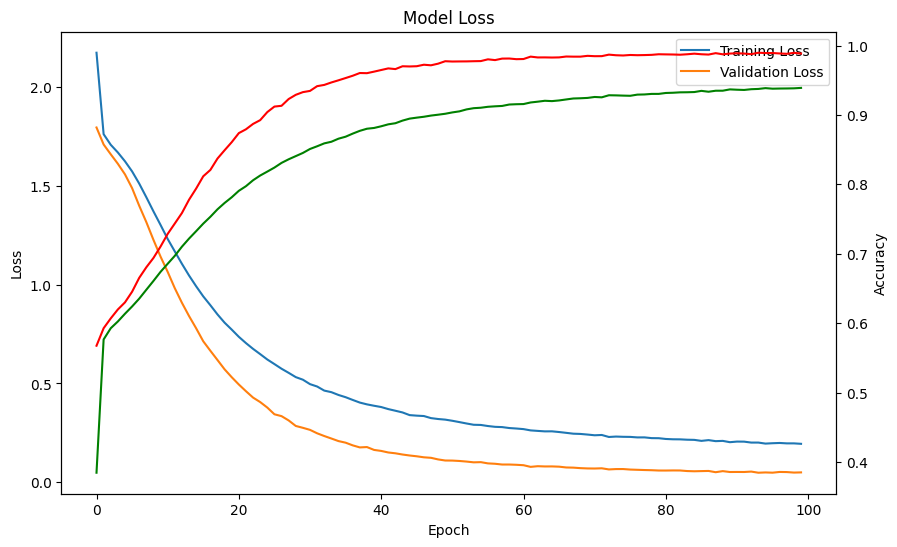

In [113]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract training and validation accuracy (if applicable)
train_acc = history.history['accuracy']  # Modify key based on your metric
val_acc = history.history['val_accuracy']  # Modify key based on your metric

# Create the plot
plt.figure(figsize=(10, 6))

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot accuracy (if applicable)
plt.twinx()  # Create a second y-axis for accuracy
plt.plot(train_acc, 'g-', label='Training Accuracy')
plt.plot(val_acc, 'r-', label='Validation Accuracy')
plt.ylabel('Accuracy')

plt.show()

In [122]:
test = 'علاج ارتفاغ السكر التراكمي'
test = tokenizer.texts_to_sequences([test])
test2 = pad_sequences(test,maxlen=20)
result = model.predict(test2)
output_class = np.argmax(result)
le.inverse_transform(np.array([output_class]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


array(['مرض-السكري'], dtype='<U24')

In [123]:
model.save('chatbotClassificationModel.h5')

In [124]:
import pickle
pickle.dump(tokenizer,open('chatbotTokinizer.pkl','wb'))
pickle.dump(le,open('chatbotLabelencoder.pkl','wb'))